# Data extraction and theoretical modeling for the split-junction nanowire circuit

## Supplementary material - 'Realization of microwave quantum circuits using hybrid superconducting-semiconducting nanowire Josephson elements'

#### G. de Lange, B. van Heck, A. Bruno, D.J. van Woerkom, A. Geresdi, S.R. Plissard, E.P.A.M. Bakkers, A.R. Akhmerov, L. DiCarlo
#### arXiv:1503.08483 

##Table of contents:

* [Import raw data](#Import-raw-data) 
* [Normalize data](#Normalize-data)
* [Voltage to flux calibration](#Voltage-to-flux-calibration)
* [Extract data points and error bars](#Extract-data-points-and-error-bars)
* [Group and merge data points](#Group-and-merge-data-points)
* [Plot extracted points against raw data](#Plot-of-extracted-data-points-against-the-raw-data)
* [Theoretical model](#Theoretical-model)
* [Fit to the short junction CPR](#Fit-to-the-short-junction-CPR)
* [Fit to the Kulik-Omelyanchuk model](#Fit-to-the-Kulik-Omelyanchuk-model)
* [Fit to the Fourier coefficients](#Fit-to-the-Fourier-coefficients)

In [1]:
%matplotlib inline
from __future__ import print_function, division
import glob
import pickle
import numpy as np
from numpy.random import random
from numpy.linalg import norm
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from scipy.integrate import quad
from scipy.special import ellipe, ellipk
import matplotlib.pyplot as plt
import mpld3

## Import raw data

In [2]:
# load data and convert it from 'NpzFile' objects to simple dicts
specs = [np.load(f) for f in glob.glob('*.npz')]
rawdata = []
for s in specs:
    new_dict = {}
    for (key, val) in s.iteritems():
        new_dict[key] = val
    new_dict.pop('descr')
    rawdata.append(new_dict)
    
#flip scan at lower frequencies
rawdata[2]['x'] = rawdata[2]['x'][::-1]
rawdata[2]['y'] = rawdata[2]['y'][::-1]
rawdata[2]['z'] = np.flipud(np.fliplr(rawdata[2]['z']))

# Truncate the range to throw away noisy regions in the last dataset.
rawdata[-1]['z'] = rawdata[-1]['z'][5:75,400:901]
rawdata[-1]['x'] = rawdata[-1]['x'][5:75]
rawdata[-1]['y'] = rawdata[-1]['y'][400:901]

# Invert last dataset to transform minima into maxima.
rawdata[-1]['z'] = 1/rawdata[-1]['z']

In [3]:
def plot_datascan(d):
    z = d['z'].T[::-1]
    x = d['x']
    y = d['y']
    
    dx, dy = x[1]-x[0], y[1]-y[0]
    ranges = [x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2]
    
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.imshow(z, extent = ranges, aspect='auto', interpolation='none', cmap='gist_heat_r')
    #ax.set_xlabel('Voltage [V]')
    #ax.set_ylabel('Frequency [GHz]')
    cbar = fig.colorbar(cax)
    ax.autoscale(False)

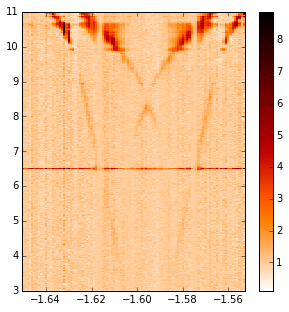

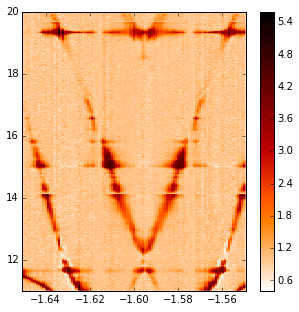

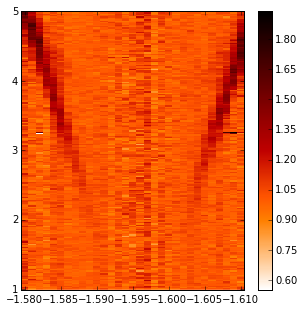

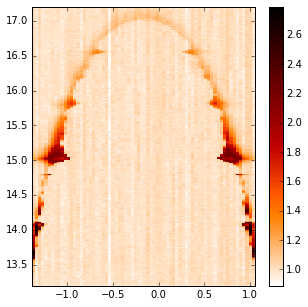

In [4]:
for d in rawdata:
    plot_datascan(d)

## Normalize data

In [5]:
# we'd like to keep the raw data separately
data = list(rawdata)
for d in data:
    z = d['z']
    z = gaussian_filter(z, [1, 4])
    z = z - np.percentile(z, 60, axis=0)[None, ...]
    z = z - np.median(z, axis=1)[..., None]    
    d['z'] = z[:, :-1]  # Throw away the last point to make the shape divisible by 10.

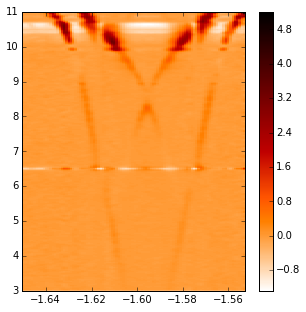

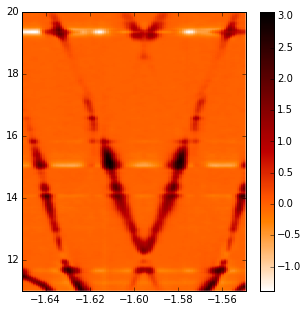

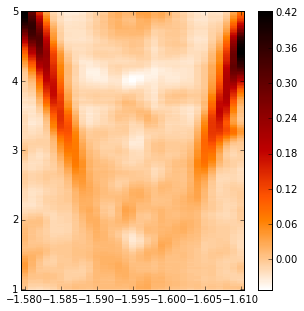

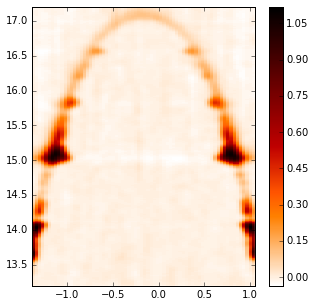

In [6]:
for d in data:
    plot_datascan(d)

## Voltage to flux calibration

We want to convert the voltage axis into a flux axis. We assume a linear relation $V(\Phi) = a \Phi + b$. The flux $\Phi$ is expressed in units of the flux quantum $h/2e$. We extract $V(0)$ and $V(0.5)$ by finding two axis of reflection symmetry in the data scans, and then compute $a$ and $b$

We first find $V(0)$ from the last dataset.

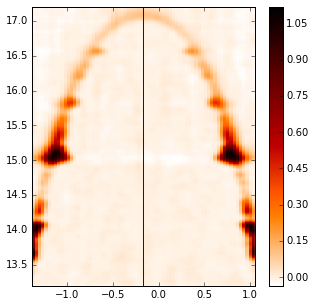

In [7]:
z = data[3]['z']
left = z[5:20] # select a slice for comparison on the left of the dataset
# find most symmetric slice on right part of the dataset
idx = np.argmin([norm(left-np.flipud(z[n:n+15])) for n in xrange(len(z)-15)])
# compute middle point between symmetric slices
x1, x2 = data[3]['x'][19], data[3]['x'][idx]
V0 = x1 + (x2 - x1) / 2
plot_datascan(data[3])
plt.axvline(V0)

Now we find $V(0.5)$ from the second dataset.

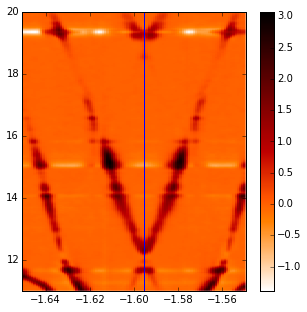

In [8]:
z = data[1]['z']
left = z[20:35]
idx = np.argmin([norm(left-np.flipud(z[n:n+15])) for n in xrange(len(z)-15)])
x1, x2 = data[1]['x'][34], data[1]['x'][idx]
Vhalf = x1 + (x2 - x1) / 2
plot_datascan(data[1])
plt.axvline(Vhalf)

In [9]:
a, b = 2 * (Vhalf - V0), V0
for d in data:
    d['x'] -= b
    d['x'] /= a

## Extract data points and error bars

In [10]:
lines = []
for num, d in enumerate(data):
    z = d['z']
    z = np.mean(z.reshape(len(z), -1, 5), axis=-1)
    y = d['y'][:-2:5]    
    x = np.vstack([d['x'] for n in range(len(y))]).T
    y = np.vstack([y for n in range(len(x))])
    zthresh = z > np.percentile(z, 80)
    
    # Separate a group to catch 1 --> 4 transitions
    if num == 1:
        zthresh[40:60, 155] = False
        
    
    label_objects, nb_labels = ndimage.label(zthresh, structure=np.ones((3,3)))
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > (20 if num==1 else 70)  # Again to catch 1-->4 transition
    mask_sizes[0] = 0
    numbers = np.argwhere(mask_sizes).flatten()
    znew = np.zeros(z.shape)
    for num2 in numbers:
        ztmp = z * (label_objects == num2)
        ztmp /= np.max(ztmp, axis=0)[None, ...] + 1e-8  # The addition is to avoid division by zero
        # Since we are working with a single segment, we don't really need to fit a Gaussian anymore,
        # average and variance are good enough.
        averages = np.ma.average(y, axis=1, weights=ztmp)
        stds = np.sqrt(np.ma.average((y - averages[..., None])**2, axis=1, weights=ztmp))
        fluxes = np.ma.masked_where(averages.mask, x[:, 0]).compressed()
        lines.append(zip(fluxes, averages.compressed(), stds.compressed()))
        znew += ztmp

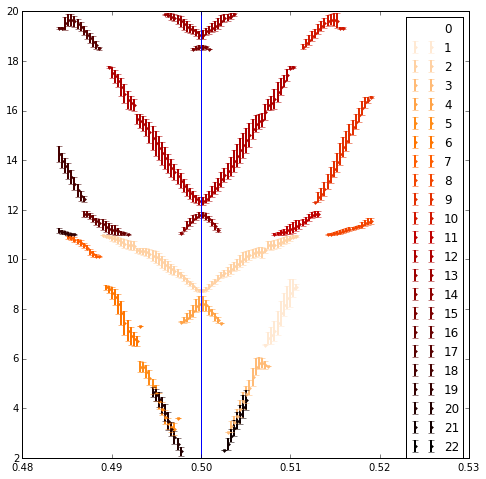

In [11]:
# Choose a color sequence to distinguish different groups of points
from matplotlib import cm
ncol = len(lines)
cmap = cm.gist_heat_r
col_ind = np.linspace(0, 256, ncol)
col_array = cmap(col_ind.astype(int))


fig, ax = plt.subplots(figsize=(8,8))
for n, (l, col) in enumerate(zip(lines, col_array)):
    x, y, yerr = zip(*l)
    ax.errorbar(x, y, yerr=yerr, label=n, linewidth=0, fmt='.', elinewidth=2, c=col)
ax.legend()
ax.set_ylim(2, 20)
ax.set_xlim(0.48, 0.53)
ax.axvline(0.5)

## Group and merge data points

The extracted data points are divided in sets of neighboring points. We manually group those sets which form a single, continuous dispersing line.

In [12]:
w01 = lines[0] + lines[1] + lines[3] + lines[5] + lines[6] + lines[7] + lines[8] + lines[19] + lines[20] + lines[21] + lines[22] 
w02 = lines[2] + lines[9] + lines[11] + lines[16] + lines[16] + lines[18]
w03 = lines[10] + lines[12] + lines[17]
w04 = lines[13]
w12 = lines[4]
w13 = lines[14]
w14 = lines[15]
transitions = [w01, w02, w03, w04, w12, w13, w14]
transitions = [np.asarray(t) for t in transitions]

We also merge overlapping points with the same flux coordinate. These were typically split by the presence of flat resonances during the automated data extraction.

In [13]:
for (n, t) in enumerate(transitions):
    t = t[t[:,-1] > 1e-4] # Discard wrong points with no err
    t = t[t[:,0].argsort()] # Orders array according to first column
    t[:,0] = np.floor(1e7 * t[:,0]) / 1e7 # Set floating point accuracy to decide on 'equal x coordinate'
    xs = np.unique(t[:,0])
    new_t = np.zeros((len(xs), 3))
    for (num, x) in enumerate(xs):
        points = t[np.where(t[:,0] == x)]
        new_t[num,:] = np.sum(points, axis=0)
        new_t[num,:2] /= len(points) # take the average x and y coordinates
    # Finally, cut points with uncertainty too small.
    # The threshold is ~ cavity linewidth.
    transitions[n] = new_t[new_t[:,-1] > 0.056]

## Plot of extracted data points against the raw data

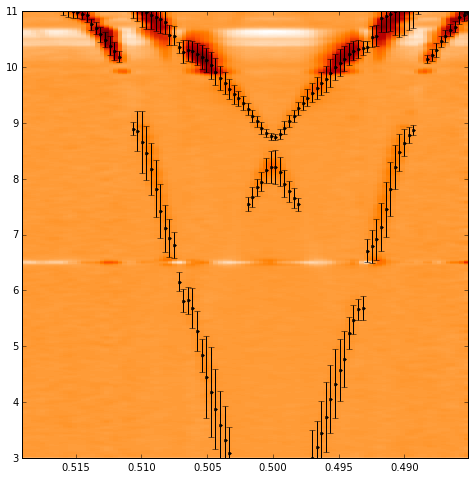

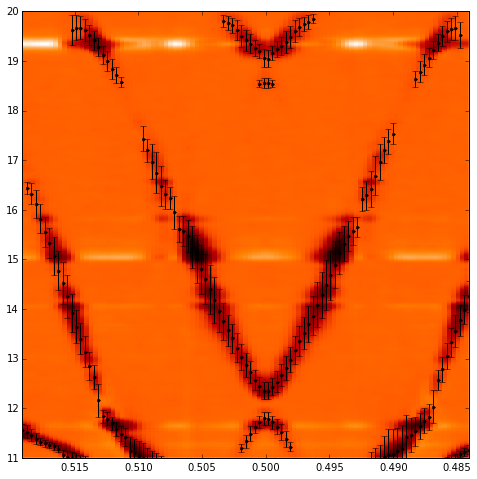

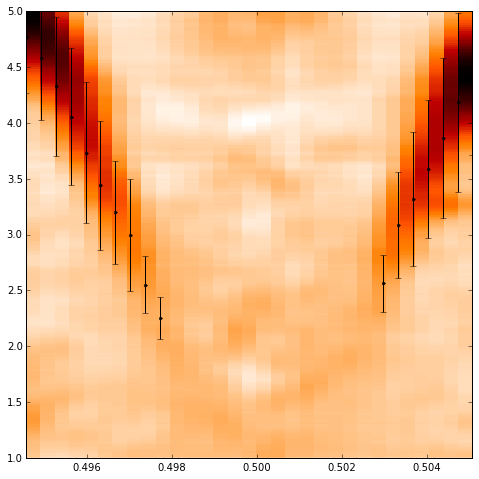

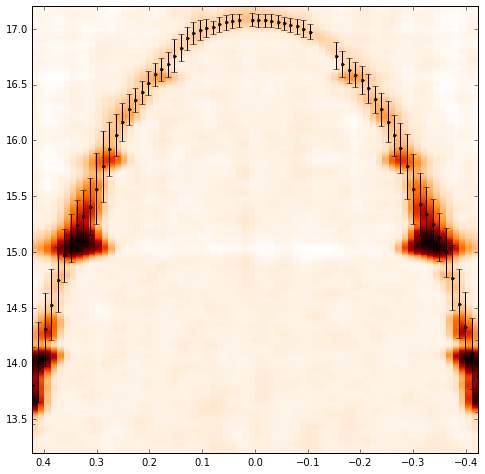

In [14]:
for num, d in enumerate(rawdata):
    z = d['z'].T[::-1]
    x = d['x']
    y = d['y']
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(z, extent = [x[0], x[-1], y[0], y[-1]],
              aspect='auto', interpolation='none', cmap='gist_heat_r')
    ax.autoscale(False)
    for t in transitions:
        flux, freq, freq_err = zip(*t)
        ax.errorbar(flux, freq, yerr = freq_err, linewidth=0, fmt='.', elinewidth=1, c='k')

## Theoretical model

In [15]:
N = 100  # Hilbert space is truncated to 2*N+1 charge state.
def ham(Ec, ng, flux, c1, c2):
    """ Returns the model Hamiltonian as a dense matrix,
    written in the charge basis.

    Parameters:
    -----------
    Ec, ng, flux : float
        Charging energy, induced charge and flux.
    c1, c2 : list of floats.
        Fourier coefficients of the Josephson
        energy of first and second junction.
    """
    alpha = np.exp(- 1j * flux)
    H = np.diag(4 * Ec * (np.arange(-N, N+1) - ng)**2) + 0j
    for n, c in enumerate(c1, start=1):
        H -= 0.5 * c * (np.eye(2*N+1, k=n) + np.eye(2*N+1, k=-n))
    for n, c in enumerate(c2, start=1):
        H -= 0.5 * c * (alpha**n * np.eye(2*N+1, k=n)
                        + (alpha.conj())**n * np.eye(2*N+1, k=-n))                   
    return H

## Fit to the short junction CPR

In [16]:
def fourier_coefs_short_junc_cpr(T):
    """ Returns the Fourier coefficients of the function
    
    V(phi) = Sqrt[1-T*sin(phi/2)]
    
    with T a real parameter/ The coefficients can be computed
    explicitly and expressed in terms of elliptic integrals.
    """
    eleT = ellipe(T)
    elkT = ellipk(T)
    a1 = (2 / (3 * np.pi * T)) * (-2 * (T-2) * eleT + 4 * (T-1) * elkT)
    a2 = (2 / (15 * np.pi * T**2)) * (-2 * (16 + (T - 16) * T) * eleT + 16 * (T - 2)*(T - 1) * elkT)
    a3 = (2 / (105 * np.pi * T**3)) * (-2 * (-2 + T) * (128 + T * (-128 + 3 * T)) * eleT + 
                                        4 * (-1 + T) * (128 + T * (-128 + 27 * T)) * elkT)
    a4 = (2 / (315 * np.pi * T**4)) * (-2 * (2048 + T * (-4096 + T * (2496 + T * (-448 + 5 * T)))) * eleT + 
                                        64 * (-2 + T) * (-1 + T) * (32 + T * (-32 + 5 * T)) * elkT)
    a5 = (2 / (3465 * np.pi * T**5)) * (-2 * (-2 + T) * (32768 + T * (-65536 + T * (38016 + T * (-5248 + 35 * T)))) * eleT + 
                                         4 * (-1 + T) * (32768 + T * (-65536 + T * (44160 + T * (-11392 + 875 * T)))) * elkT)
    a6 = (2 / (45045 * np.pi * T**6)) * (-2 * \
               (2621440 + T * (-7864320 + T * (8781824 + T * (-4456448 + T * (990768 + T * (-73264 + 315 * T)))))) * eleT + 
                16 * (-2 + T) * (-1 + T) * (163840 + T * (-327680 + T * (210944 + T * (-47104 + 2835 * T)))) * elkT)
    a7 = (2 / (45045 * np.pi * T**7)) * (-2 * (-2 + T) *\
               (4194304 + T * (-12582912 + T * (13795328 + T * (-6619136 + T * (1288704 + T * (-76288 + 231 * T)))))) * eleT + 
                4 * (-1 + T) * (4194304 +  T*(-12582912+T*(14581760+T*(-8192000+T*(2284032+T*(-285184+11319*T)))))) * elkT)
    return np.array([a1, a2, a3, a4, a5, a6, a7])


def rs_short_junc_cpr(plist, xs, ys, sigmas, idx):
    """ Returns the list of residuals between the data points
    and the transition energies, given a list of Hamiltonian parameters,
    for the CPR V(phi) = Sqrt[1-T*sin(phi/2)].

    Parameters:
    -----------
    plist : list of floats
        List of Hamiltonian parameters.
    xs : 1d array
        X values of the data.
    ys : 1d array
        Y values of the data.
    sigmas: 1d array
        Y data errors.
    idx : list
        Indices which mark the beginning of data corresponding
        to different transition lines. It is used to associate each
        data point to the correct transition energy.

    Return:
    ------
    1d array of weighted residuals.
    """
    
    Ec, Ej1, Ej2, T1, T2 = plist
    # Imposes that c1 list corresponds to strongest junction
    # by returning very large list of residuals
    if not ((0 < T1 < 1) and (0 < T2 < 1)):
        return (ys + 200)
    
    c1, c2 = list(Ej1 * fourier_coefs_short_junc_cpr(T1)), list(Ej2 * fourier_coefs_short_junc_cpr(T2))
    phis = 2 * np.pi * xs
    hams = [ham(Ec, 0., phi, c1, c2) for phi in phis] # Induced charge fixed at zero.
    eigs = [np.sort(np.linalg.eigvalsh(h))[:5] for h in hams]
    energies = np.hstack(([eig[1] - eig[0] for eig in eigs[:idx[0]]],
                          [eig[2] - eig[0] for eig in eigs[idx[0]:idx[1]]],
                          [eig[3] - eig[0] for eig in eigs[idx[1]:idx[2]]],
                          [eig[4] - eig[0] for eig in eigs[idx[2]:idx[3]]],
                          [eig[2] - eig[1] for eig in eigs[idx[3]:idx[4]]],
                          [eig[3] - eig[1] for eig in eigs[idx[4]:idx[5]]],
                          [eig[4] - eig[1] for eig in eigs[idx[5]:]]))
    weights = 1. / sigmas
    return (energies - ys) * weights

def fit_short_junc_cpr(lines, p0):
    """
    Returns the best estimate for the parameters p0 and their
    covariance matrix.

    The obtain the covariance matrix, the jacobian around the
    solution returned by leastsq is multiplied by the residual variance

    s = sum(rs) / (n-m)

    where n is the number of data points and m the number of fitting
    parameters. This is the same as what is done in scipy.optimize.curve_fit.
    
    Parameters:
    -----------
    lines : list
        List of lists of points to be fitted, one list for every
        different transition.
    p0 : list
        Initial guess for the fitting parameters.
    """
    fit_result = {'initial_guess' : p0}
    xs, ys, sigmas = np.asarray(zip(*np.vstack(l for l in lines)))
    lengths = [len(l) for l in lines]
    idxs = [sum(lengths[:n]) for n in np.arange(1, 7)]
    (popt, pcov, infodict, errmsg, ier) = leastsq(rs_short_junc_cpr, x0=p0, args=(xs, ys, sigmas, idxs), full_output=1)
    chi_squared = (np.asarray(rs_short_junc_cpr(popt, xs, ys, sigmas, idxs))**2).sum()
    chi_squared /= (len(xs) - len(popt))
    pcov = pcov * chi_squared
    std_devs = np.sqrt(np.diag(pcov))
    fit_result['popt'] = popt
    fit_result['chi_squared'] = chi_squared
    fit_result['infodict'] = infodict
    fit_result['pcov'] = pcov
    fit_result['std_devs'] = std_devs
    fit_result['errmsg'] = errmsg
    fit_result['ier'] = ier
    return fit_result

In [17]:
def plot_results(fit_result, transitions, method='fourier'):
    """ Convenience function to compare results of a fit
    to the extracted data point"""
    
    if method=='short_jj':
        popt, chi2 = fit_result['popt'], fit_result['chi_squared']
        Ec, Ej1, Ej2, T1, T2 = popt
        c1, c2 = list(Ej1 * fourier_coefs_short_junc_cpr(T1)), list(Ej2 * fourier_coefs_short_junc_cpr(T2))
    elif method=='ko':
        popt, chi2 = fit_result['popt'], fit_result['chi_squared']
        coefs = np.array([fourier_coefficients_ko_model(n) for n in xrange(1, fit_result['num_fourier'])])
        Ec, Ej1, Ej2 = popt
        c1, c2 = Ej1*coefs, Ej2*coefs
    elif method=='fourier':
        popt, n1, n2, chi2 = fit_result['popt'], fit_result['n1'], fit_result['n2'], fit_result['chi_squared']
        Ec, c1, c2 = popt[0], popt[1:n1+1], popt[n1+1:]
        print("Results for (n1, n2)=(%s, %s)" % (n1, n2))    
    
    fluxes = np.hstack((np.linspace(-np.pi, 0.48*2*np.pi, 200),
                        np.linspace(0.48*2*np.pi, 0.52*2*np.pi, 200)))
    fit_lines = [[] for i in xrange(7)]
    fit_lines_prime = [[] for i in xrange(7)]
    for flux in fluxes:
        H = ham(Ec, 0., flux, c1, c2) #Induced charge set to zero
        eigs = np.linalg.eigvalsh(H)[:5]
        transition_energies = np.hstack((eigs[1:]-eigs[0], eigs[2:]-eigs[1]))
        for fit_l, diff in zip(fit_lines, transition_energies):
            fit_l.append(diff)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,12))
    f.subplots_adjust(wspace=0)

    
    ncol = len(transitions)
    cmap = cm.brg
    col_ind = np.linspace(20, 180, ncol)
    colors = cmap(col_ind.astype(int))
    #colors = ['b', 'b', 'b', 'b', 'g', 'g', 'g']
    for (t, en, col) in zip(transitions, fit_lines, colors):
        xs, ys, sigmas = zip(*t)
        ax1.errorbar(xs, ys, yerr=sigmas, linewidth=0, fmt='', elinewidth=1, c=col)
        condition = ((fluxes > 2 * np.pi * min(xs)) & 
                     (fluxes < 2 * np.pi * max(xs)))
        phi = fluxes[np.where(condition)] / (2*np.pi)
        transition = np.array(en)[np.where(condition)]
        ax1.plot(phi, transition, c='k', linewidth=1.5)
        ax1.set_xlim(-0.45, 0.45)
    
    for (t, en, col) in zip(transitions, fit_lines,colors):
        xs, ys, sigmas = zip(*t)
        ax2.errorbar(xs, ys, yerr=sigmas, linewidth=0, fmt='', elinewidth=1, c=col)
        condition = ((fluxes > 2 * np.pi * min(xs)) & 
                     (fluxes < 2 * np.pi * max(xs)))
        phi = fluxes[np.where(condition)] / (2*np.pi)
        transition = np.array(en)[np.where(condition)]
        ax2.plot(phi, transition, c='k', linewidth=1.5)
        ax2.set_xlim(0.482, 0.519)
        ax2.set_xticks([0.49, 0.50, 0.51])
        ax2.set_ylim(0, 20)
    plt.figure()
    plt.close()

In [18]:
# The two commented out lines execute and store the fit (may take several minutes).
# fit_short_junction = fit_short_junc_cpr(transitions, p0=[0.32, 200, 100, 0.6, 0.6])
# pickle.dump(fit_short_junction, open('fit_short_junction.pickle', 'wb'))
fit_short_junction = pickle.load(open('fit_short_junction.pickle', 'rb'))

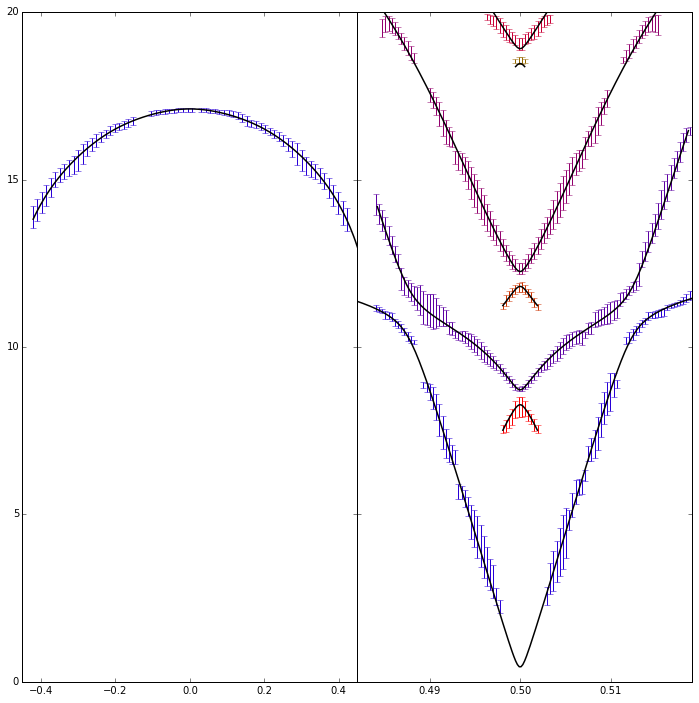

In [19]:
plot_results(fit_short_junction, transitions, method='short_jj')

Best fit values for the short junction fit:

$E_C = 279 \pm 1$ MHz 

$K_1 = 376 \pm 12$ GHz

$K_2 = 233 \pm 2 $ GHz

$T_1 = 0.86 \pm 0.02$

$T_2 = 0.885 \pm 0.003$

## Fit to the Kulik-Omelyanchuk model

In [20]:
def jos_energy_ko(phi):
    """ Josephson energy for the Kulik-Omelyanchuk model"""
    x = np.sin(phi/2)**2
    return 2 * ellipe(x)


def fourier_coefficients_ko_model(n):
    """ Returns the first n Fourier coefficients of the 
    Josephson energy of the Kulim-Omelyanchuk model"""
    g = lambda phi: jos_energy_ko(phi) * np.cos(phi*n)
    coef = quad(g, 0., 2*np.pi)[0]
    if n==0:
        coef /= 2
    return coef / np.pi


def rs_ko(plist, xs, ys, sigmas, idx, nfourier):
    """ Returns the list of residuals between the data points
    and the transition energies, given a list of Hamiltonian parameters,
    for the Kulim-Omelyanchuk CPR.

    With respect to rs_short_junc_cpr, it has an additional parameter
    nfourier, an integer which specifies the number of Fourier
    coefficients to include.
    """
    Ec, Ej1, Ej2 = plist
    fourier_coefficients = np.array([fourier_coefficients_ko_model(n) for n in xrange(1, nfourier)])
    c1 = Ej1 * fourier_coefficients
    c2 = Ej2 * fourier_coefficients
    phis = 2 * np.pi * xs
    hams = [ham(Ec, 0., phi, c1, c2) for phi in phis] # Induced charge fixed at zero.
    eigs = [np.sort(np.linalg.eigvalsh(h))[:5] for h in hams]
    energies = np.hstack(([eig[1] - eig[0] for eig in eigs[:idx[0]]],
                          [eig[2] - eig[0] for eig in eigs[idx[0]:idx[1]]],
                          [eig[3] - eig[0] for eig in eigs[idx[1]:idx[2]]],
                          [eig[4] - eig[0] for eig in eigs[idx[2]:idx[3]]],
                          [eig[2] - eig[1] for eig in eigs[idx[3]:idx[4]]],
                          [eig[3] - eig[1] for eig in eigs[idx[4]:idx[5]]],
                          [eig[4] - eig[1] for eig in eigs[idx[5]:]]))
    weights = 1. / sigmas
    return (energies - ys) * weights


def fit_ko(lines, p0, num_fourier=15):
    """
    Returns the best estimate for the parameters p0 and their
    covariance matrix, for the Kulik-Omelyanchul model.
    """
    fit_result = {'initial_guess' : p0}
    fit_result['num_fourier'] = num_fourier
    xs, ys, sigmas = np.asarray(zip(*np.vstack(l for l in lines)))
    lengths = [len(l) for l in lines]
    idxs = [sum(lengths[:n]) for n in np.arange(1, 7)]
    (popt, pcov, infodict, errmsg, ier) = leastsq(rs_ko, x0=p0,
                                                  args=(xs, ys, sigmas, idxs, num_fourier), full_output=1)
    chi_squared = (np.asarray(rs_ko(popt, xs, ys, sigmas, idxs, num_fourier))**2).sum()
    chi_squared /= (len(xs) - len(popt))
    pcov = pcov * chi_squared
    std_devs = np.sqrt(np.diag(pcov))
    fit_result['popt'] = popt
    fit_result['chi_squared'] = chi_squared
    fit_result['infodict'] = infodict
    fit_result['pcov'] = pcov
    fit_result['std_devs'] = std_devs
    fit_result['errmsg'] = errmsg
    fit_result['ier'] = ier
    return fit_result

In [21]:
# The two commented out lines execute and store the fit (may take several minutes).
# fit_results_k0 = fit_ko(transitions, p0=[0.27, 200, 140])
# pickle.dump(fit_results_ko, open('fit_ko.pickle', 'wb'))
fit_ko_results = pickle.load(open('fit_ko.pickle', 'rb'))

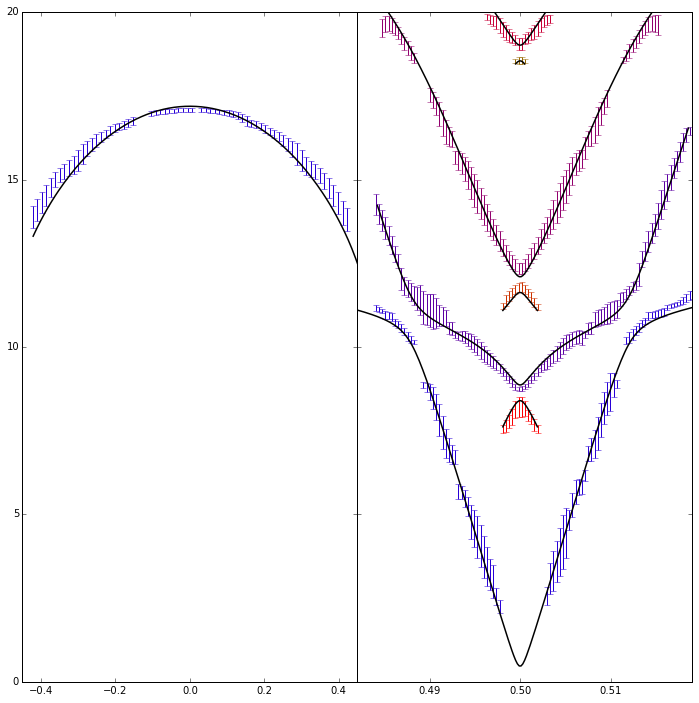

In [22]:
plot_results(fit_ko_results, transitions, 'ko')

Best fit values for the Kulik-Omelyanchuk model:

$E_C = 265 \pm 1$ MHz 

$K_1 = 218 \pm 1$ GHz

$K_2 = 141 \pm 1 $ GHz

## Fit to the Fourier coefficients

In [23]:
def rs_fourier(plist, xs, ys, sigmas, idx, n1, n2, alternating_signs=True):
    """ Returns the list of residuals between the data points
    and the transition energies, for a given set of Hamiltonian
    parameters.

    Parameters:
    -----------
    plist : list of floats
        List of Hamiltonian parameters.
    xs : 1d array
        X values of the data.
    ys : 1d array
        Y values of the data.
    sigmas: 1d array
        Y data errors.
    idx : list
        Indices which mark the beginning of data corresponding
        to different transition lines. It is used to associate each
        data point to the correct transition energy.
    n1, n2 : int
        Number of coefficients in plist to attribute to the
        first and second Josephson junction.

    Return:
    ------
    1d array of weighted residuals.
    """
    Ec, c1, c2 = plist[0], plist[1:n1+1], plist[n1+1:n1+n2+1]
    
    # Imposes that c1 list corresponds to strongest junction
    # by returning very large list of residuals
    if c1[0] < c2[0]:
        return (ys + 200)

    if alternating_signs:
        cond1 = np.all(np.abs(np.diff(np.sign(c1))))
        cond2= np.all(np.abs(np.diff(np.sign(c2))))
        if not (cond1 and cond2):
            print("Signs not alternating!!")
            return (ys + 200)
    
    phis = 2 * np.pi * xs
    hams = [ham(Ec, 0., phi, c1, c2) for phi in phis] # Induced charge fixed at zero.
    eigs = [np.sort(np.linalg.eigvalsh(h))[:5] for h in hams]
    energies = np.hstack(([eig[1] - eig[0] for eig in eigs[:idx[0]]],
                          [eig[2] - eig[0] for eig in eigs[idx[0]:idx[1]]],
                          [eig[3] - eig[0] for eig in eigs[idx[1]:idx[2]]],
                          [eig[4] - eig[0] for eig in eigs[idx[2]:idx[3]]],
                          [eig[2] - eig[1] for eig in eigs[idx[3]:idx[4]]],
                          [eig[3] - eig[1] for eig in eigs[idx[4]:idx[5]]],
                          [eig[4] - eig[1] for eig in eigs[idx[5]:]]))
    weights = 1. / sigmas
    return (energies - ys) * weights


def fit_to_fourier_coefficients(lines, p0, n1, n2):
    """
    Returns the best estimate for the parameters p0 and their
    covariance matrix.

    The obtain the covariance matrix, the jacobian around the
    solution returned by leastsq is multiplied by the residual variance

    s = sum(rs) / (n-m)

    where n is the number of data points and m the number of fitting
    parameters. This is the same as what is done in scipy.optimize.curve_fit.
    
    Parameters:
    -----------
    lines : list
        List of lists of points to be fitted, one list for every
        different transition.
    p0 : list
        Initial guess for the fitting parameters.
    n1, n2 : int
        Number of coefficients to be attributed to the
        first and second Josephson junction.
    """
    fit_result = {'n1' : n1, 'n2' : n2}
    xs, ys, sigmas = np.asarray(zip(*np.vstack(l for l in lines)))
    lengths = [len(l) for l in lines]
    idxs = [sum(lengths[:n]) for n in np.arange(1, 7)]
    (popt, pcov, infodict, errmsg, ier) = leastsq(rs_fourier, x0=p0, args=(xs, ys, sigmas, idxs, n1, n2), full_output=1)
    chi_squared = (np.asarray(rs_fourier(popt, xs, ys, sigmas, idxs, n1, n2))**2).sum()
    chi_squared /= (len(xs) - len(popt))
    pcov = pcov * chi_squared
    std_devs = np.sqrt(np.diag(pcov))
    fit_result['initial_guess'] = p0
    fit_result['popt'] = popt
    fit_result['chi_squared'] = chi_squared
    fit_result['infodict'] = infodict
    fit_result['pcov'] = pcov
    fit_result['std_devs'] = std_devs
    fit_result['errmsg'] = errmsg
    fit_result['ier'] = ier
    return fit_result

In [24]:
# The two commented out lines execute and store the fit (may take several minutes).
# fit_fourier = fit_to_fourier_coefficients(transitions, p0 = [0.32, 100, 50, -10, 2, -0.5, 0.1], n1=1, n2=5)
# pickle.dump(fit_fourier, open('fit_fourier.pickle', 'wb'))
fit_fourier = pickle.load(open('fit_fourier.pickle', 'rb'))

Results for (n1, n2)=(1, 5)


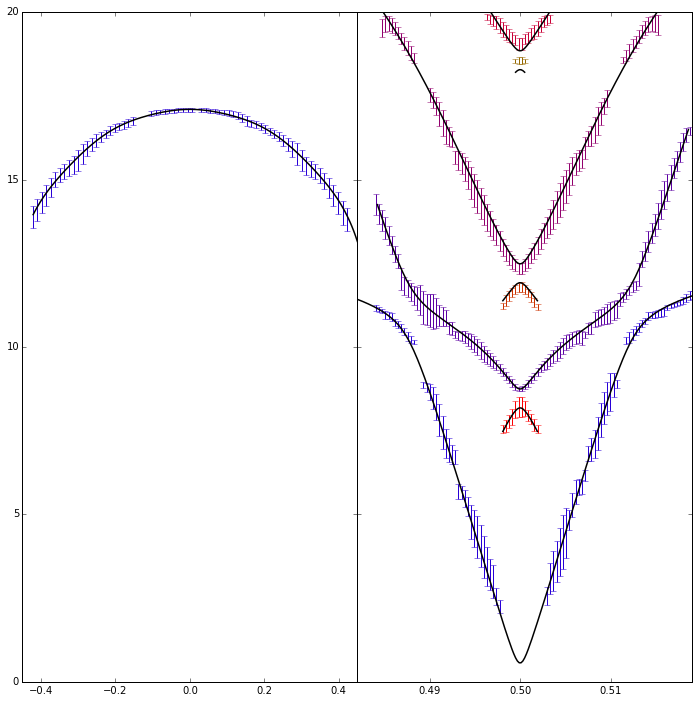

In [25]:
plot_results(fit_fourier, transitions)

Best values for the seven-parameter fit to Fourier coefficients:

$E_C = 275 \pm 1$ MHz

$A_{1,1} = 95.5 \pm 0.4$ GHz

$A_{2,1} = 68.9 \pm 0.2$ GHz

$A_{2,2} = -11.8 \pm 0.1$ GHz

$A_{2,3} = 3.28 \pm 0.02$ GHz

$A_{2,4} = -0.98 \pm 0.03$ GHz

$A_{2,5} = 0.21 \pm 0.03$ GHz